In [ ]:
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy
!pip uninstall shapely
!pip install shapely --no-binary shapely
!pip install netCDF4

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [21]:
import numpy as np
import h5py
from netCDF4 import Dataset

In [10]:
path = './'
fname = '2A.GPM.DPR.V9-20211125.20220903-S214230-E231504.048385.V07A.HDF5'

In [11]:
h5f=h5py.File(path+fname,'r')
print(h5f, flush=True)

<HDF5 file "2A.GPM.DPR.V9-20211125.20220903-S214230-E231504.048385.V07A.HDF5" (mode r)>


In [12]:
lon = h5f['FS/Longitude']
lat = h5f['FS/Latitude']
lon, lat

(<HDF5 dataset "Longitude": shape (7937, 49), type "<f4">,
 <HDF5 dataset "Latitude": shape (7937, 49), type "<f4">)

In [13]:
rainrate = h5f['FS/SLV/precipRateNearSurface'][:,:]
lon = h5f['FS/Longitude'][:,:]
lat = h5f['FS/Latitude'][:,:]
rainrate.shape, lon.shape, lat.shape

((7937, 49), (7937, 49), (7937, 49))

In [14]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

In [15]:
def plot_background(ax):
    ax.set_extent([110,140,10,40.],crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    return ax

In [16]:
def pcolormesh(lon, lat, data, var, unit, projection, size, cmap, mindata, maxdata):
    fig = plt.figure(figsize=size)
    ax = plt.axes(projection=projection)
    #rotated_pole = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)
    cf1 = ax.pcolormesh(lon, lat, data, cmap=cmap, transform=ccrs.PlateCarree(), vmin=mindata, vmax=maxdata)
    ax.coastlines()
    ax.set_extent([110,140,10,40])
    ax.set_title(var, size='xx-large')

    cbar = plt.colorbar(cf1, orientation="vertical", 
                        pad=0.1,shrink=0.8) 
    cbar.set_label(unit, size='x-large')

    gl=ax.gridlines(draw_labels=True,x_inline=False, y_inline=False)
    gl.xlabels_top = False
    gl.ylabels_left = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}
    plt.show()

/scratch/q593a01/.conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/scratch/q593a01/.conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


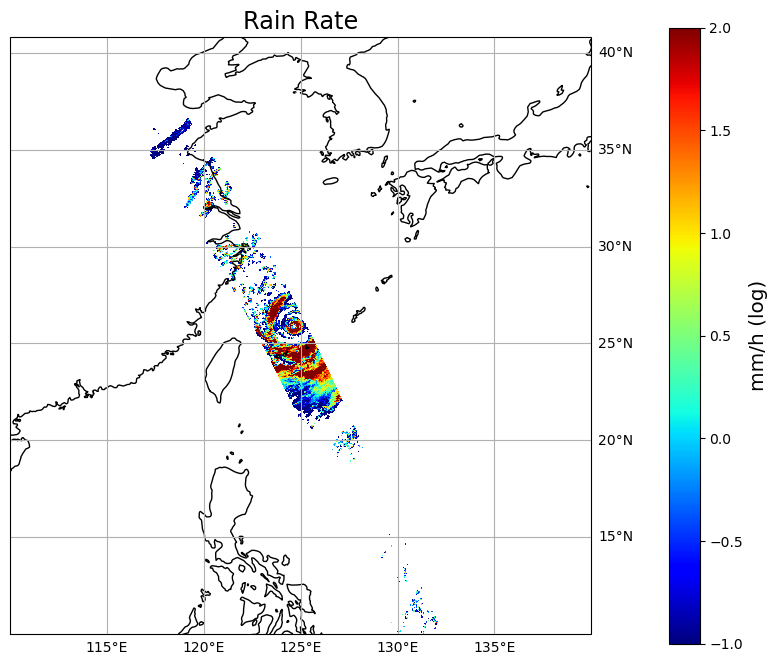

In [20]:
rainrate_log = np.log(rainrate)
pcolormesh(lon, lat,  rainrate_log,'Rain Rate', 'mm/h (log)', ccrs.PlateCarree(), (10,10), 'jet', -1, 2)

In [26]:
nc_path = './work/00/'
nc_fname='gk2a_ami_le1b_ir105_fd020ge_202209032240.nc'

nc=Dataset(nc_path+nc_fname,'r', format='netcdf4')
ncdata=nc['image_pixel_values'] #data=nc.variables['image_pixel_values']와 같음
print(ncdata)
data=nc.variables['image_pixel_values'][:,:]
print(data)

<class 'netCDF4._netCDF4.Variable'>
uint16 image_pixel_values(dim_image_y, dim_image_x)
    channel_name: IR105
    detector_side: 2
    number_of_total_pixels: 30250000
    number_of_error_pixels: 0
    max_pixel_value: 32768
    min_pixel_value: 2701
    average_pixel_value: 11311.110947801653
    stddev_pixel_value: 11950.089217827595
    number_of_total_bits_per_pixel: 16
    number_of_data_quality_flag_bits_per_pixel: 2
    number_of_valid_bits_per_pixel: 13
    data_quality_flag_meaning: 0:good_pixel, 1:conditionally_usable_pixel, 2:out_of_scan_area_pixel, 3:error_pixel
    ground_sample_distance_ew: 5.6e-05
    ground_sample_distance_ns: 5.6e-05
unlimited dimensions: 
current shape = (5500, 5500)
filling on, default _FillValue of 65535 used
[[32768 32768 32768 ... 32768 32768 32768]
 [32768 32768 32768 ... 32768 32768 32768]
 [32768 32768 32768 ... 32768 32768 32768]
 ...
 [32768 32768 32768 ... 32768 32768 32768]
 [32768 32768 32768 ... 32768 32768 32768]
 [32768 32768 32768 ..

In [24]:
mask = 0b0001111111111111 #13bit mask
ipixel_process_masked=np.bitwise_and(data,mask)
np.bitwise_and(13, 17) 

1

In [29]:
CT_path='../CSR/Convection/ct_table/'
AL_postfix='_con_alb.txt'
BT_postfix='_con_bt.txt'

channel=ncdata.getncattr('channel_name')
print(channel)

conversion_table=np.loadtxt(CT_path+channel+BT_postfix,'float64')
data_converted=conversion_table[ipixel_process_masked]
data_converted.shape, np.min(data_converted), np.max(data_converted)

IR105


((5500, 5500), 160.169215, 330.052569)

In [33]:
latlon = Dataset('gk2a_ami_fd020ge_latlon.nc', 'r', format = 'netcdf4')
print(latlon)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    satellite_name: GK-2A
    instrument_name: AMI
    data_processing_center: NMSC
    total_pixel_data_size: 30250000
    projection: Geostationary
    area: FD
    number_of_columns: 5500
    number_of_lines: 5500
    reference: http://nmsc.kma.go.kr
    dimensions(sizes): dim_x(5500), dim_y(5500)
    variables(dimensions): float32 lat(dim_y, dim_x), float32 lon(dim_y, dim_x)
    groups: 


In [34]:
lat_nc = latlon.variables['lat'][:,:]
lon_nc = latlon.variables['lon'][:,:]

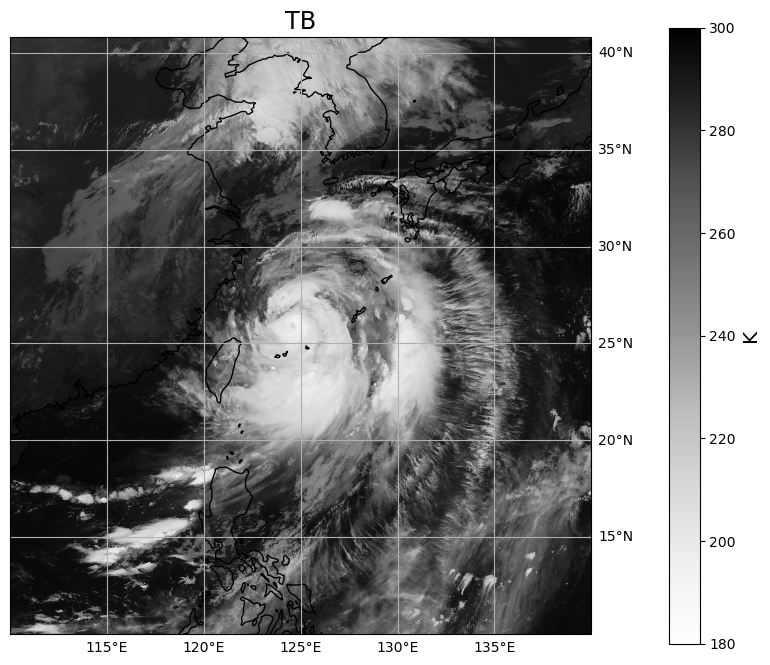

In [37]:
pcolormesh(lon_nc, lat_nc, data_converted,'TB', 'K', ccrs.PlateCarree(), (10,10), 'Greys', 180, 300)

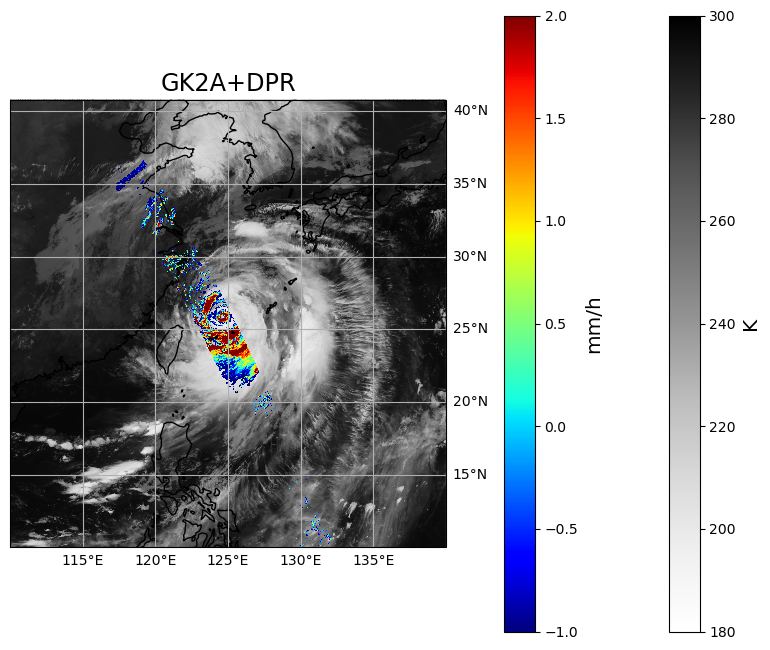

In [38]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
#rotated_pole = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)
cf1 = ax.pcolormesh(lon_nc, lat_nc, data_converted, cmap='Greys', transform=ccrs.PlateCarree(), vmin=180, vmax=300)
cf2 = ax.pcolormesh(lon, lat,  rainrate_log, cmap='jet', transform=ccrs.PlateCarree(), vmin=-1, vmax=2)

ax.coastlines()
ax.set_extent([110,140,10,40])
ax.set_title('GK2A+DPR', size='xx-large')

cbar1 = plt.colorbar(cf1, orientation="vertical", 
                    pad=0.1,shrink=0.8)
cbar1.set_label('K', size='x-large')
cbar2 = plt.colorbar(cf2, orientation="vertical", 
                    pad=0.1,shrink=0.8) 
cbar2.set_label('mm/h (log)', size='x-large')

gl=ax.gridlines(draw_labels=True,x_inline=False, y_inline=False)
gl.xlabels_top = False
gl.ylabels_left = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
plt.show()

In [47]:
np.where((lon_nc>120.00) & (lon_nc<120.02)&(lat_nc>30.00)& (lat_nc<30.02))

(array([1210]), array([2366]))

In [48]:
lon_nc[1210,2366], lat_nc[1210,2366]

(120.00223, 30.016775)

In [94]:
i0=1210-100
j0=2366-100
i1=1210+655
j1=j0+655
print(lon_nc[i0,j0], lat_nc[i0,j0])
print(lon_nc[i1,j0], lat_nc[i1,j0])
print(lon_nc[i0,j1], lat_nc[i0,j1])
print(lon_nc[i1,j1], lat_nc[i1,j1])

117.52929 32.37324
119.00102 16.420115
131.95204 32.2757
131.44302 16.381975


In [95]:
lon_crop = lon_nc[i0:i1,j0:j1]
lat_crop = lat_nc[i0:i1,j0:j1]
data_crop = data_converted[i0:i1,j0:j1]

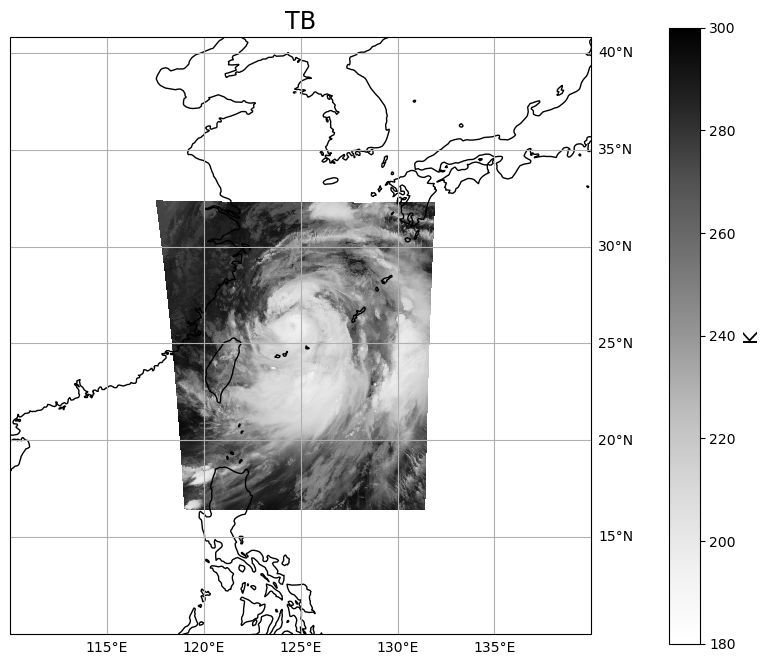

In [96]:
pcolormesh(lon_crop, lat_crop, data_crop,'TB', 'K', ccrs.PlateCarree(), (10,10), 'Greys', 180, 300)

In [57]:
np.where((lon>120.00) & (lon<120.02)&(lat>30.00)& (lat<30.5))

(array([5192]), array([48]))

In [62]:
i0=5192
j0=0
i1=5192+333
j1=j0+48
print(lon[i0,j0], lat[i0,j0])
print(lon[i1,j0], lat[i1,j0])
print(lon[i0,j1], lat[i0,j1])
print(lon[i1,j1], lat[i1,j1])

122.259056 31.585083
128.91757 18.100224
120.00061 30.43856
126.83888 17.069927


In [63]:
dlon_crop = lon[i0:i1,j0:j1]
dlat_crop = lat[i0:i1,j0:j1]
ddata_crop = rainrate_log[i0:i1,j0:j1]

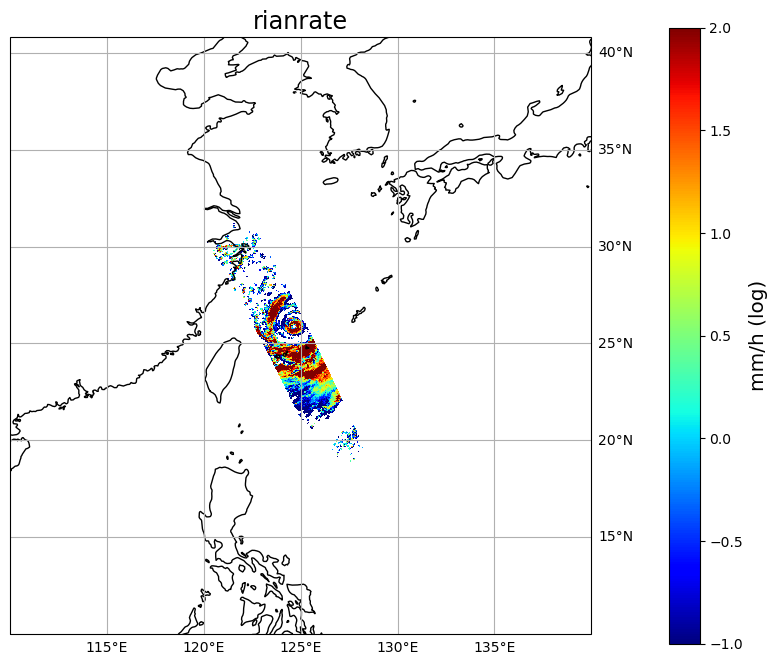

In [64]:
pcolormesh(dlon_crop, dlat_crop, ddata_crop,'rianrate', 'mm/h (log)', ccrs.PlateCarree(), (10,10), 'jet', -1, 2)

In [65]:
gridx, gridy = np.mgrid[20:30:222j, 120:130:222j]
gridx, gridy

(array([[20.        , 20.        , 20.        , ..., 20.        ,
         20.        , 20.        ],
        [20.04524887, 20.04524887, 20.04524887, ..., 20.04524887,
         20.04524887, 20.04524887],
        [20.09049774, 20.09049774, 20.09049774, ..., 20.09049774,
         20.09049774, 20.09049774],
        ...,
        [29.90950226, 29.90950226, 29.90950226, ..., 29.90950226,
         29.90950226, 29.90950226],
        [29.95475113, 29.95475113, 29.95475113, ..., 29.95475113,
         29.95475113, 29.95475113],
        [30.        , 30.        , 30.        , ..., 30.        ,
         30.        , 30.        ]]),
 array([[120.        , 120.04524887, 120.09049774, ..., 129.90950226,
         129.95475113, 130.        ],
        [120.        , 120.04524887, 120.09049774, ..., 129.90950226,
         129.95475113, 130.        ],
        [120.        , 120.04524887, 120.09049774, ..., 129.90950226,
         129.95475113, 130.        ],
        ...,
        [120.        , 120.04524887,

In [97]:
lons = lon_crop.flatten()
lats = lat_crop.flatten()
datas = data_crop.flatten()

In [67]:
import scipy.interpolate as sinter

In [98]:
lonlat_nc = np.stack((lats, lons)).T
data_tb = sinter.griddata(lonlat_nc, datas, (gridx, gridy), method = 'nearest')

In [99]:
data_tb.shape

(222, 222)

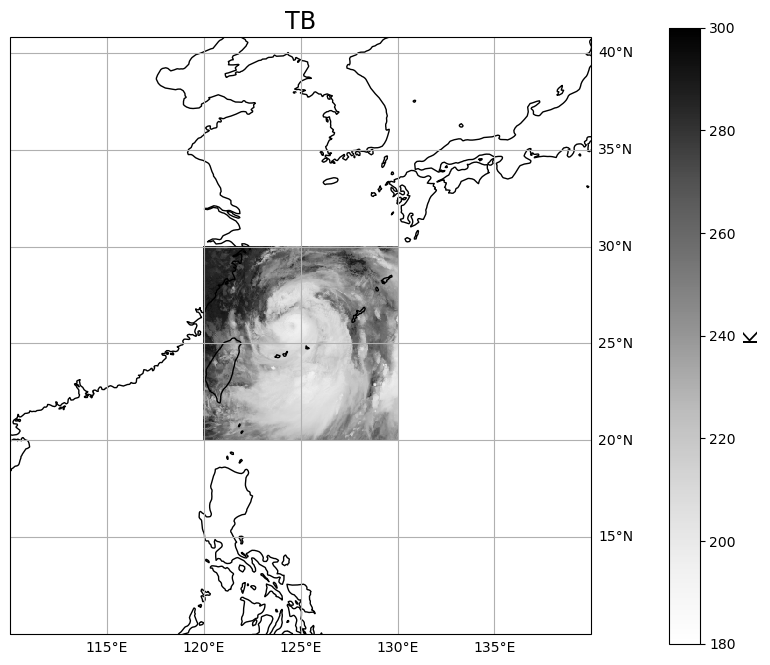

In [100]:
pcolormesh(gridy, gridx, data_tb,'TB', 'K', ccrs.PlateCarree(), (10,10), 'Greys', 180, 300)

In [101]:
dlons = dlon_crop.flatten()
dlats = dlat_crop.flatten()
ddatas = ddata_crop.flatten()

In [105]:
dlonlat_nc = np.stack((dlats, dlons)).T
data_rr = sinter.griddata(dlonlat_nc, ddatas, (gridx, gridy), method = 'linear')

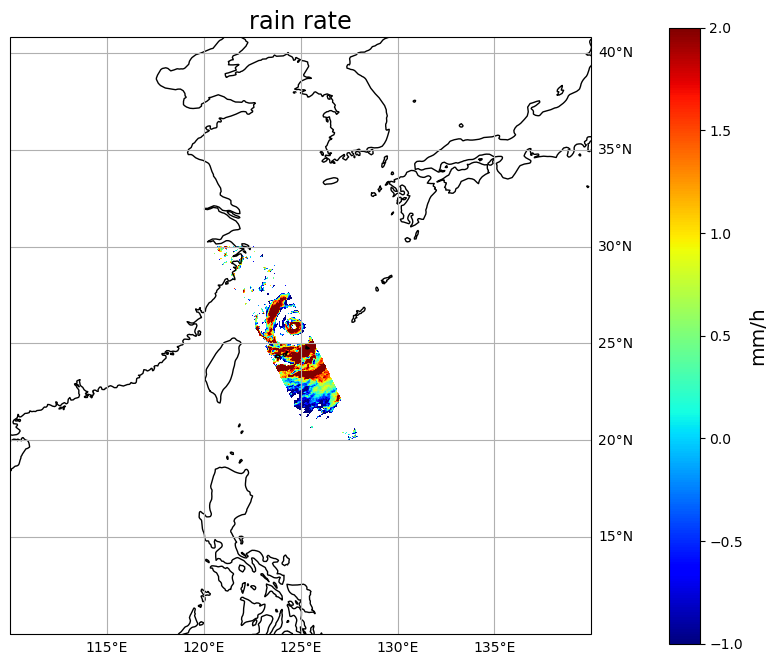

In [106]:
pcolormesh(gridy, gridx, data_rr,'rain rate', 'mm/h', ccrs.PlateCarree(), (10,10), 'jet', -1, 2)

In [107]:
data_rr.shape, data_tb.shape

((222, 222), (222, 222))

In [108]:
final_rr=data_rr[data_rr>0]
final_tb=data_tb[data_rr>0]

final_rr.shape, final_tb.shape

((4190,), (4190,))

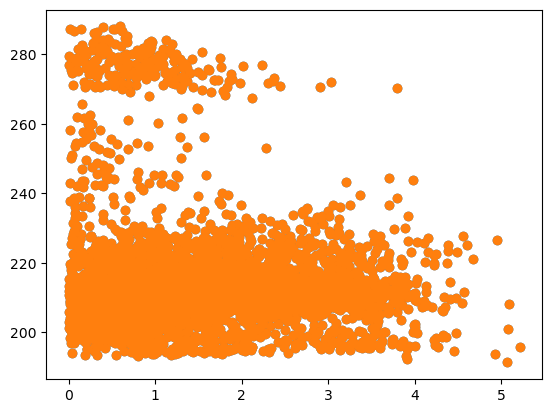

In [110]:
plt.scatter(final_rr, final_tb)
plt.show()

In [115]:
import matplotlib
plt.hist2d(final_rr.flatten(), final_tb.flatten(), bins =(50,50),norm=matplotlib.colors.LogNorm(),cmap='jet')

(array([[0., 1., 2., ..., 0., 0., 2.],
        [0., 2., 0., ..., 1., 0., 1.],
        [0., 1., 2., ..., 2., 0., 1.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]]),
 array([4.26734374e-04, 1.04735576e-01, 2.09044418e-01, 3.13353260e-01,
        4.17662101e-01, 5.21970943e-01, 6.26279785e-01, 7.30588627e-01,
        8.34897468e-01, 9.39206310e-01, 1.04351515e+00, 1.14782399e+00,
        1.25213284e+00, 1.35644168e+00, 1.46075052e+00, 1.56505936e+00,
        1.66936820e+00, 1.77367704e+00, 1.87798589e+00, 1.98229473e+00,
        2.08660357e+00, 2.19091241e+00, 2.29522125e+00, 2.39953009e+00,
        2.50383894e+00, 2.60814778e+00, 2.71245662e+00, 2.81676546e+00,
        2.92107430e+00, 3.02538315e+00, 3.12969199e+00, 3.23400083e+00,
        3.33830967e+00, 3.44261851e+00, 3.54692735e+00, 3.65123620e+00,
        3.75554504e+00, 3.85985388e+00, 3.96416272e+00, 4.06847156e+00,
        4.17278040e+00, 4.27708

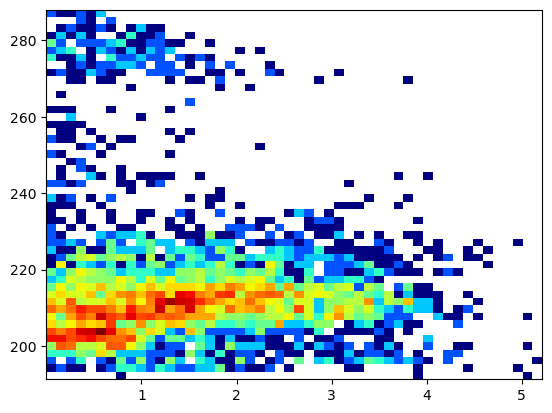

In [116]:
plt.show()